16/09/2023
# CLASS 1

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.stats as stats


### Generarción Números Aleatorios Correlacionados

Basado en: https://financioneroncios.wordpress.com/2019/01/24/montecarlo-i/

La **descomposición de Cholesky** es una técnica en álgebra lineal numérica que se utiliza principalmente en la resolución de sistemas de ecuaciones lineales y en la generación de números aleatorios correlacionados. Esta descomposición es especialmente útil cuando trabajas con matrices simétricas y definidas positivas.

Aquí hay una explicación sencilla de la descomposición de Cholesky:

1- Matriz Simétrica y Definida Positiva: La descomposición de Cholesky se aplica a una matriz cuadrada simétrica y definida positiva. Esto significa que la matriz es simétrica $A = A^{T}$ y todos sus valores propios son positivos.

2- Factorización en Matriz Triangular: La descomposición de Cholesky descompone la matriz original en el producto de dos matrices: una matriz triangular inferior ($L%$) y su traspuesta ($L^{T}$). Es decir, $A = L * L^{T}$

La vamos a usar para **Generación de Números Aleatorios Correlacionados**: Se utiliza en estadísticas y simulación para generar números aleatorios correlacionados. Puedes utilizar la matriz triangular inferior $L$ para transformar números aleatorios independientes en números aleatorios correlacionados.

Si $\left| A \right| \neq 0$ entonces $A * A^T$ es una matriz simétrica y definida positiva. Por lo tanto, podemos aplicar la descomposición de Cholesky a $A * A^T$ 


In [3]:
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'AAPL', 'MSFT']
assets.sort()

In [4]:
start = '2019-12-30'
end = '2022-12-31'

prices = yf.download(assets, start=start, end=end)['Adj Close']
ret = prices.pct_change().dropna()

[*********************100%%**********************]  8 of 8 completed


In [5]:
# Calculate statistics of daily returns
mu = ret.mean().to_numpy().reshape(-1,1) # mean vector
cov = ret.cov().to_numpy() # covariance matrix
corr = ret.corr().to_numpy() # correlation matrix
skew = ret.skew()
kurt = ret.kurt()

corr_ret = np.corrcoef(ret, rowvar=False) #Matrix of correlation of the returns



<module 'matplotlib.pyplot' from '/home/alfonso/Desktop/universidad/Portfolio-Optimization/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

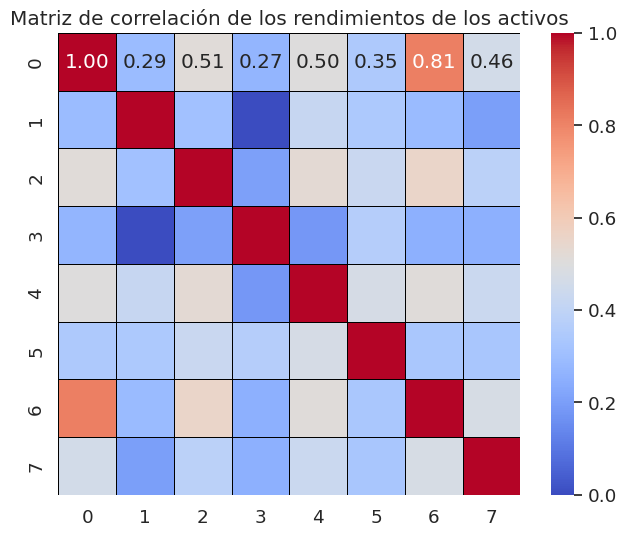

In [13]:
# Crear un mapa de calor de la matriz de covarianzas
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(corr_ret, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black', cbar=True, square=True)
plt.title('Matriz de correlación de los rendimientos de los activos')
plt

Generamos retornos de los distintos activos usando números aleatorios de una distribución normal estándar. Las muestras generadas  son independientes y se puede ver en la matriz de covarianzas.

In [7]:
# Create correlated random numbers
# https://financioneroncios.wordpress.com/2019/01/24/montecarlo-i/

T, n = ret.shape

rs = np.random.RandomState(seed=123) # Here we create like a session of random numbers

# Correlated sample assuming a gaussian copula

samp_ind = rs.randn(2000, n) # a sample from independent standard normal distribution

corr_ind = np.corrcoef(samp_ind, rowvar=False) # correlation of the independent sample




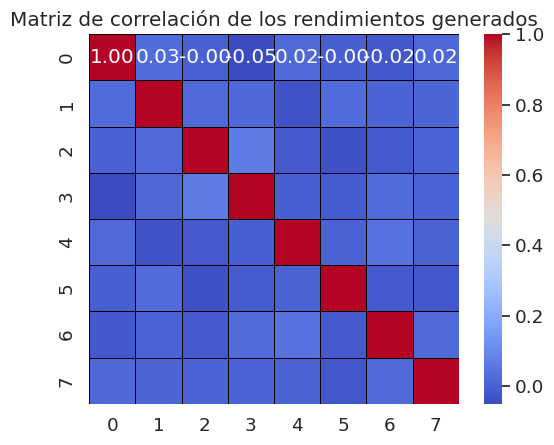

In [20]:
# Crear un mapa de calor de la matriz de covarianzas

#plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(corr_ind, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black', cbar=True, square=True)
plt.title('Matriz de correlación de los rendimientos generados')
plt.show()


Sabemos que el riesgo de una cartera depende de las relaciones entre los activos que las componen. Esto genera un problema a la hora de simular el comportamiento de una cartera, ya que no se estaría teniendo en cuenta la correlación entre los activos.

CORRELATED SAMPLE ASSUMING NORMAL CÓPULA

In [23]:
L = np.linalg.cholesky(cov) # Cholesky decomposition of the covariance matrix

samp_norm = samp_ind @ L.T + mu.T # a sample of standard normal distribution with correlation matrix corr

corr_samp_norm = np.corrcoef(samp_norm, rowvar=False) #Matrix of correlation of the generated sample using the correlation matrix


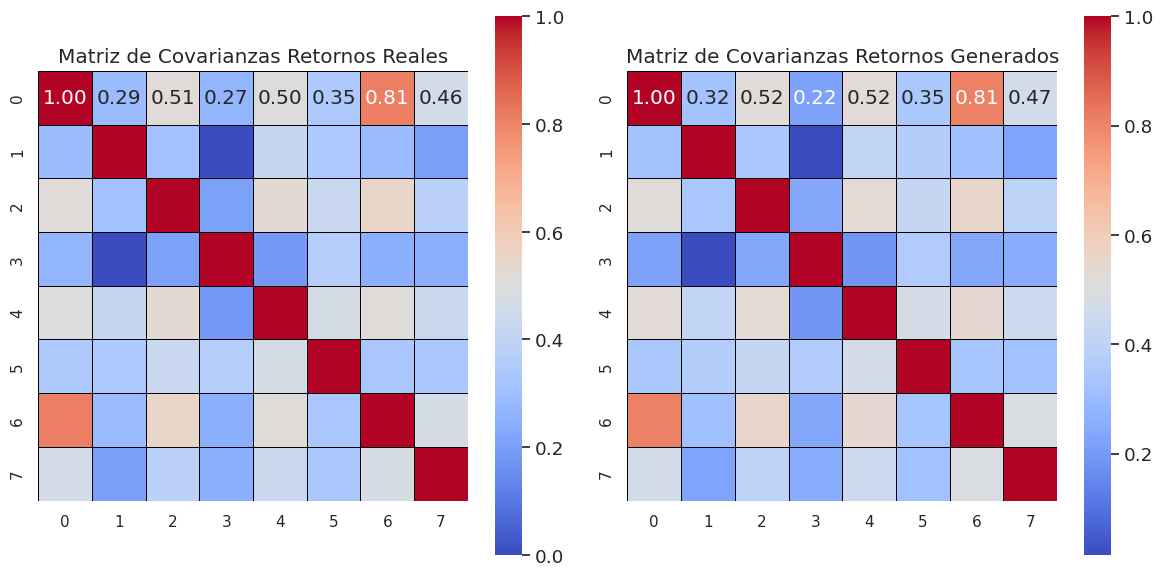

In [24]:
# Crear subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot para la primera matriz de covarianzas
sns.set(font_scale=1.2)
sns.heatmap(corr_ret, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black', cbar=True, square=True,
            ax=axs[0])
axs[0].set_title('Matriz de Covarianzas Retornos Reales')

# Plot para la segunda matriz de covarianzas
sns.heatmap(corr_samp_norm, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black', cbar=True, square=True,
            ax=axs[1])
axs[1].set_title('Matriz de Covarianzas Retornos Generados')

# Ajustar espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

<module 'matplotlib.pyplot' from '/home/alfonso/Desktop/universidad/Portfolio-Optimization/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

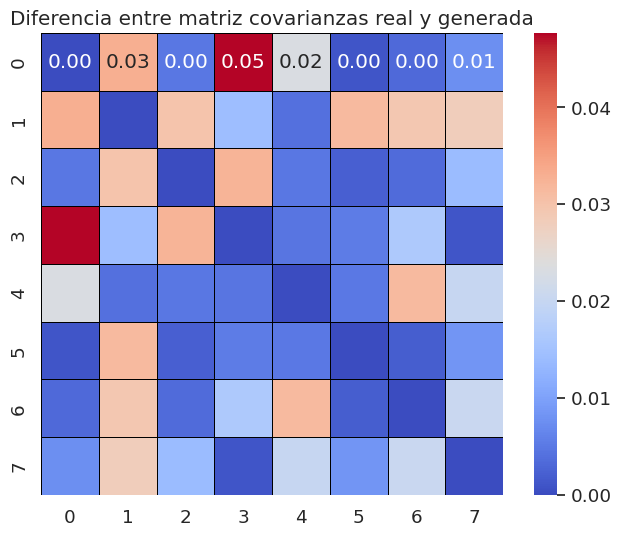

In [25]:
cov_diff_norm = np.abs(corr_ret - corr_samp_norm)

# Crear un mapa de calor de la matriz de covarianzas
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cov_diff_norm, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black', cbar=True, square=True)
plt.title('Diferencia entre matriz covarianzas real y generada')
plt


CORRELATED SAMPLE USING T-STUDENT COPULA

In [26]:

A = rs.randn(2000, n) # a sample from standard normal distribution

v = (2000 - 1) * n # degree of freedom
V = rs.chisquare(v, size = (2000, 1)) # A random sample of chi square variables

s = np.sqrt(v/V) * (A @ L.T)
samp_t = np.sqrt(v/V) * (A @ L.T) + mu.T # Correlated sample assuming a t copula

corr_samp_t = np.corrcoef(samp_t, rowvar=False)

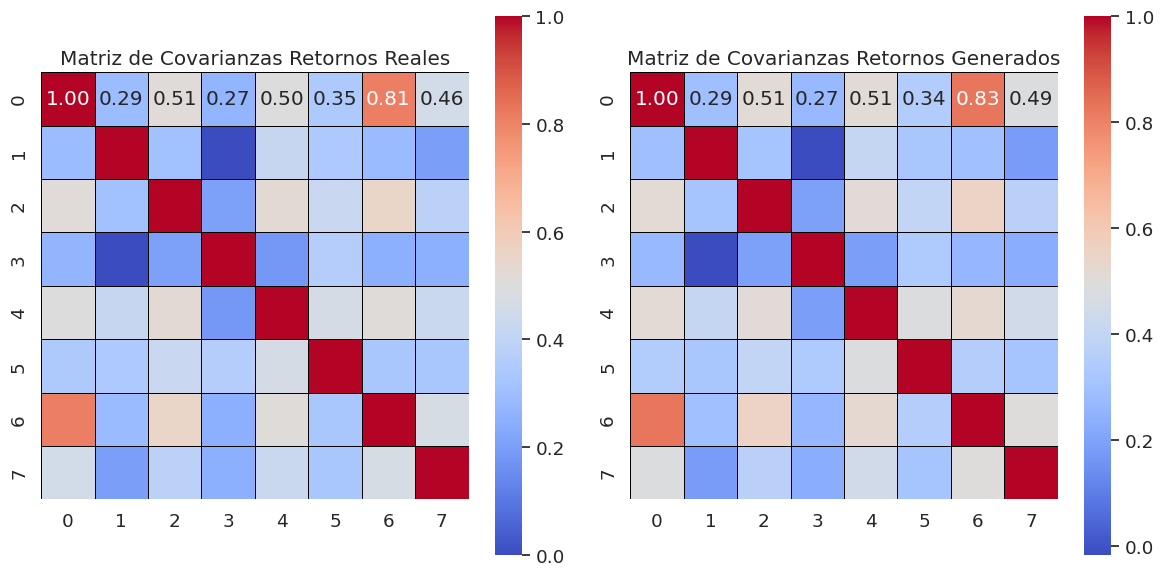

In [27]:
# Crear subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot para la primera matriz de covarianzas
sns.set(font_scale=1.2)
sns.heatmap(corr_ret, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black', cbar=True, square=True,
            ax=axs[0])
axs[0].set_title('Matriz de Covarianzas Retornos Reales')

# Plot para la segunda matriz de covarianzas
sns.heatmap(corr_samp_t, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black', cbar=True, square=True,
            ax=axs[1])
axs[1].set_title('Matriz de Covarianzas Retornos Generados')

# Ajustar espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

<module 'matplotlib.pyplot' from '/home/alfonso/Desktop/universidad/Portfolio-Optimization/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

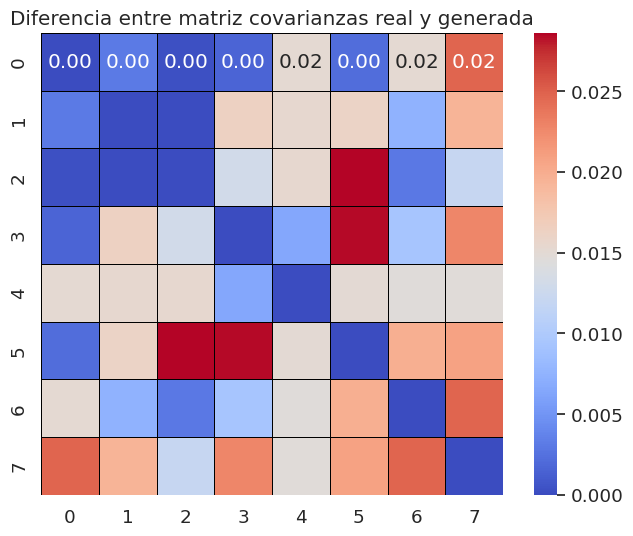

In [28]:
cov_diff_t = np.abs(corr_ret - corr_samp_t)

# Crear un mapa de calor de la matriz de covarianzas
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cov_diff_t, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black', cbar=True, square=True)
plt.title('Diferencia entre matriz covarianzas real y generada')
plt

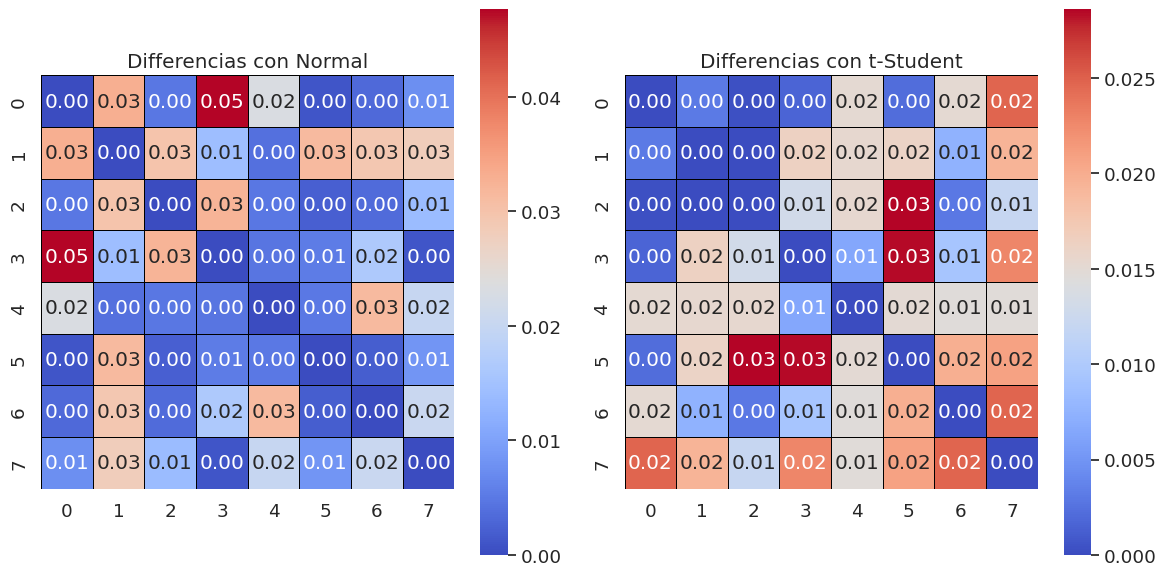

In [43]:
# Crear subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot para la primera matriz de covarianzas
sns.set(font_scale=1.2)
sns.heatmap(cov_diff_norm, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black', cbar=True, square=True,
            ax=axs[0])
axs[0].set_title('Differencias con Normal')

# Plot para la segunda matriz de covarianzas
sns.heatmap(cov_diff_t, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black', cbar=True, square=True,
            ax=axs[1])
axs[1].set_title('Differencias con t-Student')

# Ajustar espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

Hasta ahora, no hemos tenido en cuenta las varianzas de cada uno de los activos. Vamos a generar unas variables normales estándar con las correlaciones de los retornos de los activos y, además, vamos a tener en cuenta las varianzas de cada uno de los activos.

In [7]:
A = rs.randn(2000, n) # a sample from standard normal distribution
L = np.linalg.cholesky(corr)
std = np.diag(cov).reshape(-1,1) # standard deviation vector

samp_norm_std = (A @ L.T) * std.T + mu.T # multiply by the standard deviation and add the mean

corr_samp_norm_std = np.corrcoef(samp_norm_std, rowvar=False)

## GENERACIÓN DE NÚMEROS ALEATORIOS CORRELACIONADOS PERO CADA UNO CON UNA DISTRIBUCIÓN DISTINTA

Vamos a usar la librería scipy.stats que contiene, entre otras cosas, una gran cantidad de distribuciones de probabilidad y montecarlo

dirichlet lo usaremos para generar los pesos de la cartera, ya que la suma de todos los números generados es 1

wishart lo usaremos para generar la matriz de covarianzas de los casos peores y mejores para ver intervalos de confianza

sobol sequences





PRIMER PASO: Vamos a generar muestras que sigan distintas distribuciones de probabilidad utilizando la inversa de la función de distribución acumulada (CDF) de cada una de las distribuciones. Para ello, vamos a utilizar la función ppf de la librería scipy.stats.
- Generamos números aleatorios de distribución uniforme entre 0 y 1 que serán las probabilidades de cada uno de los valores de la distribución de probabilidad que queremos generar
- Utilizando la función ppf de la librería scipy.stats, generamos los valores de la distribución de probabilidad que queremos generar

In [53]:
X = rs.rand(6000, n) # 2000 samples of n-dimensional random vector with uniform distribution

sample_normal = stats.norm.ppf(X, loc=0, scale=1) # 2000 samples of n-dimensional random vector with normal distribution
sample_laplace = stats.laplace.ppf(X, loc=0, scale=1) # 2000 samples of n-dimensional random vector with laplace distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


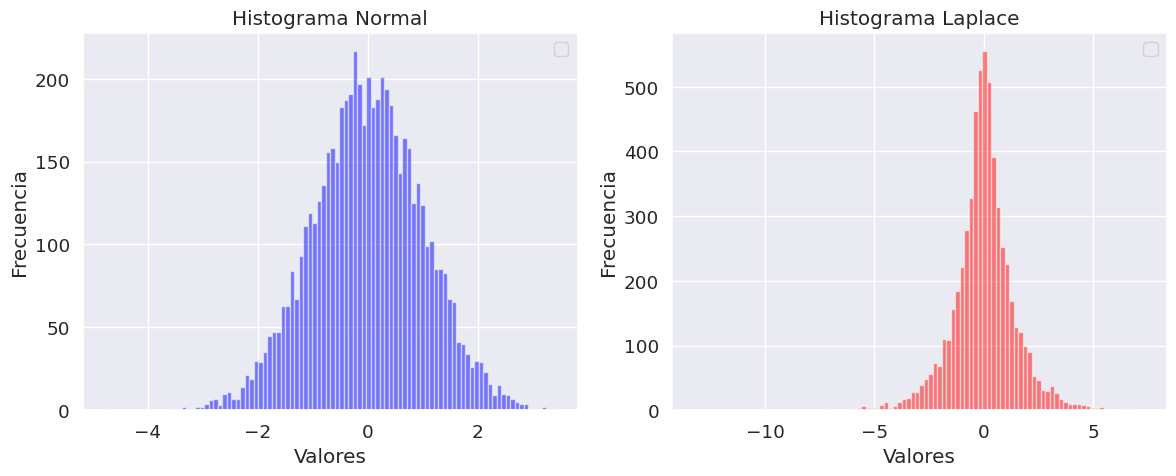

In [62]:
# Crear subplots con dos gráficas en una fila
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Primer histograma en el primer subplot
axs[0].hist(sample_normal[:, 5], bins=100, alpha=0.5, color='blue')
axs[0].set_xlabel('Valores')
axs[0].set_ylabel('Frecuencia')
axs[0].legend(loc='upper right')
axs[0].set_title('Histograma Normal')

# Segundo histograma en el segundo subplot
axs[1].hist(sample_laplace[:, 5], bins=100, alpha=0.5, color='red')
axs[1].set_xlabel('Valores')
axs[1].set_ylabel('Frecuencia')
axs[1].legend(loc='upper right')
axs[1].set_title('Histograma Laplace')

# Ajustar espacio entre subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()
